<a href="https://colab.research.google.com/github/elichen/rl-snake/blob/main/RL_snake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pygame
import random
import numpy as np
import imageio
import io
from IPython.display import Image, display, clear_output
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from collections import deque
import matplotlib.pyplot as plt

In [7]:
class Action(Enum):
    STRAIGHT = [1,0,0]
    LEFT = [0,1,0]
    RIGHT = [0,0,1]

class Direction(Enum):
    NORTH = [0, 0, 1, 0]
    EAST = [0, 1, 0, 0]
    SOUTH = [0, 0, 0, 1]
    WEST = [1, 0, 0, 0]

class SnakeGame:
    def __init__(self, width=400, height=400, grid_size=20):
        self.width = width
        self.height = height
        self.grid_size = grid_size
        self.grid_width = width // grid_size
        self.grid_height = height // grid_size
        self.snake_speed = 10
        self.black = (0, 0, 0)
        self.white = (255, 255, 255)
        self.red = (255, 0, 0)
        self.window = None
        self.clock = None
        self.reset()

    def reset(self):
        self.snake_x = self.grid_width // 2
        self.snake_y = self.grid_height // 2
        self.snake_dx, self.snake_dy = random.choice([(0, -1), (0, 1), (-1, 0), (1, 0)])
        self.snake_body = [(self.snake_x, self.snake_y)]
        self.food_x = random.randint(0, self.grid_width - 1)
        self.food_y = random.randint(0, self.grid_height - 1)
        self.score = 0
        self.frames = []
        self.game_over = False

    def get_state(self):
        snake_x, snake_y = self.snake_body[-1]
        food_x, food_y = self.food_x, self.food_y

        if self.snake_dx == -1:
            snake_direction = Direction.WEST.value
        elif self.snake_dx == 1:
            snake_direction = Direction.EAST.value
        elif self.snake_dy == -1:
            snake_direction = Direction.NORTH.value
        else:  # self.snake_dy == 1
            snake_direction = Direction.SOUTH.value

        food_direction = [0, 0, 0, 0]  # [WEST, EAST, NORTH, SOUTH]
        if food_x < snake_x:
            food_direction[0] = 1  # WEST
        if food_x > snake_x:
            food_direction[1] = 1  # EAST
        if food_y < snake_y:
            food_direction[2] = 1  # NORTH
        if food_y > snake_y:
            food_direction[3] = 1  # SOUTH

        if snake_direction == Direction.WEST.value:
            danger_straight = (snake_x - 1 < 0) or ((snake_x - 1, snake_y) in self.snake_body)
            danger_right = (snake_y - 1 < 0) or ((snake_x, snake_y - 1) in self.snake_body)
            danger_left = (snake_y + 1 >= self.grid_height) or ((snake_x, snake_y + 1) in self.snake_body)
        elif snake_direction == Direction.EAST.value:
            danger_straight = (snake_x + 1 >= self.grid_width) or ((snake_x + 1, snake_y) in self.snake_body)
            danger_right = (snake_y + 1 >= self.grid_height) or ((snake_x, snake_y + 1) in self.snake_body)
            danger_left = (snake_y - 1 < 0) or ((snake_x, snake_y - 1) in self.snake_body)
        elif snake_direction == Direction.NORTH.value:
            danger_straight = (snake_y - 1 < 0) or ((snake_x, snake_y - 1) in self.snake_body)
            danger_right = (snake_x + 1 >= self.grid_width) or ((snake_x + 1, snake_y) in self.snake_body)
            danger_left = (snake_x - 1 < 0) or ((snake_x - 1, snake_y) in self.snake_body)
        else:  # snake_direction == Direction.SOUTH
            danger_straight = (snake_y + 1 >= self.grid_height) or ((snake_x, snake_y + 1) in self.snake_body)
            danger_right = (snake_x - 1 < 0) or ((snake_x - 1, snake_y) in self.snake_body)
            danger_left = (snake_x + 1 >= self.grid_width) or ((snake_x + 1, snake_y) in self.snake_body)


        danger_states = [int(danger_straight), int(danger_right), int(danger_left)]
        game_state = danger_states + snake_direction + food_direction
        return game_state

    def place_food(self):
        while True:
            self.food_x = random.randint(0, self.grid_width - 1)
            self.food_y = random.randint(0, self.grid_height - 1)
            if not (self.food_x, self.food_y) in  self.snake_body:
                break

    def is_collision(self):
      collides_boundary = self.snake_x < 0 or self.snake_x >= self.grid_width or self.snake_y < 0 or self.snake_y >= self.grid_height
      collides_self = len(self.snake_body) > 1 and (self.snake_x, self.snake_y) in self.snake_body[:-1]
      return collides_boundary or collides_self

    def move(self, action):
        if action == Action.LEFT.value:
            self.snake_dx, self.snake_dy = self.snake_dy, -self.snake_dx
        elif action == Action.RIGHT.value:
            self.snake_dx, self.snake_dy = -self.snake_dy, self.snake_dx
        elif action == Action.STRAIGHT.value:
            pass  # Keep the current direction
        self.snake_x += self.snake_dx
        self.snake_y += self.snake_dy
        self.snake_body.append((self.snake_x, self.snake_y))

    def play_step(self, action):
        reward = 0

        self.move(action)

        if self.snake_x == self.food_x and self.snake_y == self.food_y:
            self.score += 1
            reward = 10
            self.place_food()
        else:
            self.snake_body.pop(0)

        if self.is_collision() or len(self.frames) > 100*len(self.snake_body):
            reward = -10
            self.game_over = True
            return reward, self.game_over, self.score

        self.window.fill(self.black)
        for body_part in self.snake_body:
            pygame.draw.rect(self.window, self.white, [body_part[0] * self.grid_size, body_part[1] * self.grid_size, self.grid_size, self.grid_size])
        pygame.draw.rect(self.window, self.red, [self.food_x * self.grid_size, self.food_y * self.grid_size, self.grid_size, self.grid_size])
        pygame.display.update()

        frame = pygame.surfarray.array3d(pygame.display.get_surface())
        frame = np.swapaxes(frame, 0, 1)
        self.frames.append(frame)

        self.clock.tick(self.snake_speed)
        return reward, self.game_over, self.score

    def save_gif(self):
        gif_data = io.BytesIO()
        writer = imageio.get_writer(gif_data, format='GIF', duration=1/self.snake_speed)
        for frame in self.frames:
            writer.append_data(frame)
        writer.close()
        gif_data.seek(0)
        return gif_data

In [8]:
class HeuristicController:
    def get_action(self, game_state):
        danger_straight, danger_right, danger_left = game_state[:3]
        snake_direction = game_state[3:7]
        food_direction = game_state[7:]

        preferred_actions = []

        # Determine preferred actions based on food direction relative to snake
        if snake_direction == Direction.NORTH.value:
            if food_direction[2]:  # Food is North
                preferred_actions = [Action.STRAIGHT, Action.LEFT, Action.RIGHT]
            elif food_direction[3]:  # Food is South
                preferred_actions = [Action.LEFT, Action.RIGHT, Action.STRAIGHT]
            elif food_direction[0]:  # Food is West
                preferred_actions = [Action.LEFT, Action.STRAIGHT, Action.RIGHT]
            else:  # Food is East
                preferred_actions = [Action.RIGHT, Action.STRAIGHT, Action.LEFT]
        elif snake_direction == Direction.SOUTH.value:
            if food_direction[3]:  # Food is South
                preferred_actions = [Action.STRAIGHT, Action.LEFT, Action.RIGHT]
            elif food_direction[2]:  # Food is North
                preferred_actions = [Action.LEFT, Action.RIGHT, Action.STRAIGHT]
            elif food_direction[1]:  # Food is East
                preferred_actions = [Action.LEFT, Action.STRAIGHT, Action.RIGHT]
            else:  # Food is West
                preferred_actions = [Action.RIGHT, Action.STRAIGHT, Action.LEFT]
        elif snake_direction == Direction.WEST.value:
            if food_direction[0]:  # Food is West
                preferred_actions = [Action.STRAIGHT, Action.LEFT, Action.RIGHT]
            elif food_direction[1]:  # Food is East
                preferred_actions = [Action.LEFT, Action.RIGHT, Action.STRAIGHT]
            elif food_direction[2]:  # Food is North
                preferred_actions = [Action.RIGHT, Action.STRAIGHT, Action.LEFT]
            else:  # Food is South
                preferred_actions = [Action.LEFT, Action.STRAIGHT, Action.RIGHT]
        else:  # snake_direction == Direction.EAST
            if food_direction[1]:  # Food is East
                preferred_actions = [Action.STRAIGHT, Action.LEFT, Action.RIGHT]
            elif food_direction[0]:  # Food is West
                preferred_actions = [Action.LEFT, Action.RIGHT, Action.STRAIGHT]
            elif food_direction[3]:  # Food is South
                preferred_actions = [Action.RIGHT, Action.STRAIGHT, Action.LEFT]
            else:  # Food is North
                preferred_actions = [Action.LEFT, Action.STRAIGHT, Action.RIGHT]

        # Evaluate each preferred action for danger and select the first safe option
        for action in preferred_actions:
            if action == Action.STRAIGHT and not danger_straight:
                return Action.STRAIGHT.value
            elif action == Action.LEFT and not danger_left:
                return Action.LEFT.value
            elif action == Action.RIGHT and not danger_right:
                return Action.RIGHT.value

        # If all preferred directions are dangerous, default to any safe direction
        if not danger_straight:
            return Action.STRAIGHT.value
        elif not danger_right:
            return Action.RIGHT.value
        elif not danger_left:
            return Action.LEFT.value
        return Action.STRAIGHT.value

In [9]:
class NeuralController(nn.Module):
  def __init__(self, input_size=11, hidden_size=256, output_size=3):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

  def get_action(self, state):
    action = [0,0,0]
    prediction = self(torch.tensor(state, dtype=torch.float))
    move = torch.argmax(prediction).item()
    action[move] = 1
    return action

  def save(self, file_name="model.pth"):
    model_folder_path = "./model"
    if not os.path.exists(model_folder_path):
      os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(self.state_dict(), file_name)

  def load(self, file_name="model.pth"):
      model_folder_path = "./model"
      file_name = os.path.join(model_folder_path, file_name)
      if os.path.exists(file_name):
          self.load_state_dict(torch.load(file_name))
      else:
          print(f"No model file found at {file_name}. Ensure the model file exists and the path is correct.")

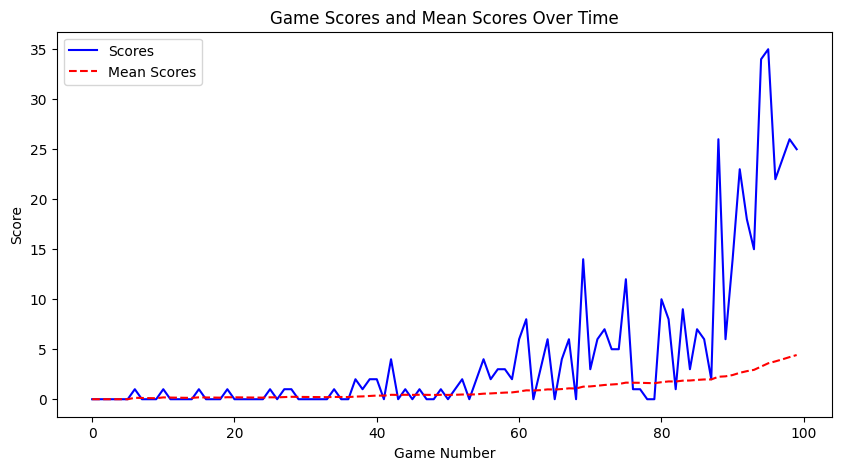

In [10]:
class QTrainer:
  def __init__(self, model, lr, gamma):
    self.lr = lr
    self.gamma = gamma
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
    self.criterion = nn.MSELoss()

  def train_step(self, state, action, reward, next_state, done):
    state = torch.tensor(state, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.long)
    reward = torch.tensor(reward, dtype=torch.float)

    if len(state.shape) == 1:
      state = state.unsqueeze(0)
      next_state = next_state.unsqueeze(0)
      action = action.unsqueeze(0)
      reward = reward.unsqueeze(0)
      done = (done, )

    pred = self.model(state)
    target = pred.clone()
    for idx in range(len(done)):
      Q_new = reward[idx]
      if not done[idx]:
        Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
      target[idx][torch.argmax(action).item()] = Q_new

    self.optimizer.zero_grad()
    loss = self.criterion(target, pred)
    loss.backward()
    self.optimizer.step()

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
  def __init__(self):
    self.n_games = 0
    self.epsilon = 0 # randomness
    self.gamma = 0.9 # discount rate
    self.memory = deque(maxlen=MAX_MEMORY)
    self.model = NeuralController()
    self.trainer = QTrainer(self.model, LR, self.gamma)

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def train_long_memory(self):
    if len(self.memory) > BATCH_SIZE:
      mini_sample = random.sample(self.memory, BATCH_SIZE)
    else:
      mini_sample = self.memory
    states, actions, rewards, next_states, dones = zip(*mini_sample)
    self.trainer.train_step(states, actions, rewards, next_states, dones)

  def train_short_memory(self, state, action, reward, next_state, done):
    self.trainer.train_step(state, action, reward, next_state, done)

  def get_action(self, state):
    self.epsilon = 80 - self.n_games
    if random.randint(0,200) < self.epsilon:
      action = [0,0,0]
      move = random.randint(0,2)
      action[move] = 1
    else:
      action = self.model.get_action(state)
    return action

def plot(plot_scores, plot_mean_scores):
    clear_output(wait=True)  # Clear the output of the cell
    plt.figure(figsize=(10, 5))  # Create a new figure
    plt.plot(plot_scores, label='Scores', color='blue')  # Plot the scores
    plt.plot(plot_mean_scores, label='Mean Scores', color='red', linestyle='--')  # Plot the mean scores
    plt.xlabel('Game Number')  # Add an X-axis label
    plt.ylabel('Score')  # Add a Y-axis label
    plt.title('Game Scores and Mean Scores Over Time')  # Add a title
    plt.legend()  # Add a legend
    display(plt.gcf())  # Display the current figure
    plt.close()  # Close the figure to prevent it from being displayed again in the output

def train():
  plot_scores = []
  plot_mean_scores = []
  total_score = 0
  record = 0
  agent = Agent()
  game = SnakeGame()
  pygame.init()
  game.window = pygame.display.set_mode((game.width, game.height))
  pygame.display.set_caption("Snake Game")
  game.clock = pygame.time.Clock()
  while agent.n_games < 100:
    state_old = game.get_state()
    action = agent.get_action(state_old)
    reward, game_over, score = game.play_step(action)
    state_new = game.get_state()
    agent.train_short_memory(state_old, action, reward, state_new, game_over)
    agent.remember(state_old, action, reward, state_new, game_over)
    if game_over:
      game.reset()
      agent.n_games += 1
      agent.train_long_memory()
      if score > record:
        record = score
        agent.model.save()
      print("Game:",agent.n_games, "Score:",score, "Record:",record)
      plot_scores.append(score)
      total_score += score
      mean_score = total_score / agent.n_games
      plot_mean_scores.append(mean_score)
      plot(plot_scores, plot_mean_scores)

train()

Final Score: 26


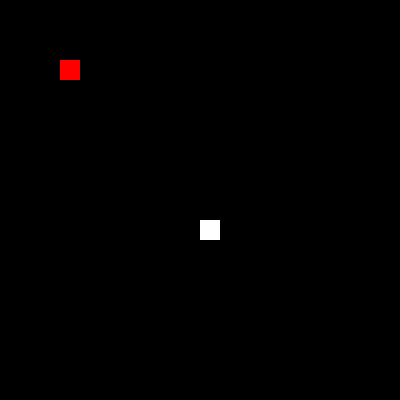

In [11]:
game = SnakeGame()
controller = NeuralController()
controller.load()

pygame.init()
game.window = pygame.display.set_mode((game.width, game.height))
pygame.display.set_caption("Snake Game")
game.clock = pygame.time.Clock()

game.reset()
while True:
    action = controller.get_action(game.get_state())
    reward, game_over, score = game.play_step(action)
    if game_over:
        break

print(f"Final Score: {score}")

pygame.quit()

gif_data = game.save_gif()
display(Image(data=gif_data.getvalue(), format='gif'))